In [1]:
#import dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
!pip install fancyimpute
from fancyimpute import IterativeImputer

from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from sklearn.inspection import permutation_importance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 7.4 MB/s 
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29899 sha256=612d8328380411d285e6315e7b57cf15ece9948b4c8695c3ebda9223a223b99f
  Stored in directory: /root/.cache/pip/wheels/e3/04/06/a1a7d89ef4e631ce6268ea2d8cde04f7290651c1ff1025ce68
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11353 sha256=e3e1ca801727fbc288d6aade1b074a78489acaf32fceb41d5791df1a1cf823f3
  Stored in directory: /root/.cache/pip/wheels/72/21/a8/a045cacd9838abd5643f6bfa852c0796a99d6b1494760494e0
Successfully built fancyimpute knnimpute


In [3]:
# load dataset
weatherdata = pd.read_csv('weather.csv')

# EDA and Preprocessing

In [4]:
#copy of wetherdata
df = weatherdata.copy()

#drop columns(either based on variance or outliers)
irrelavant_features = ['M_PACKET_FORMAT', 'M_GAME_MAJOR_VERSION', 'M_GAME_MINOR_VERSION', 'M_PACKET_VERSION', 
                       'M_PACKET_ID', 'M_FRAME_IDENTIFIER', 'M_SECONDARY_PLAYER_CAR_INDEX', 'M_BRAKING_ASSIST', 'M_SESSION_LINK_IDENTIFIER', 
                       'M_PIT_RELEASE_ASSIST', 'M_ZONE_START', 'M_ZONE_FLAG', 'M_GAME_PAUSED', 'M_SLI_PRO_NATIVE_SUPPORT', 
                       'M_SAFETY_CAR_STATUS', 'M_ERSASSIST','M_FORMULA', 'M_PIT_ASSIST', 'M_GEARBOX_ASSIST', 'M_SPECTATOR_CAR_INDEX', 'M_DYNAMIC_RACING_LINE_TYPE', 
                       'M_PIT_SPEED_LIMIT', 'M_NETWORK_GAME', 'M_STEERING_ASSIST', 'M_IS_SPECTATING', 'M_DYNAMIC_RACING_LINE', 
                       'M_DRSASSIST', 'M_NUM_MARSHAL_ZONES','GAMEHOST','Unnamed: 58']

df.drop(columns=irrelavant_features,inplace=True)

#split the feats into discrete and continous
cont_feats = [feat for feat in df.columns if df[feat].nunique()>50]
cat_feats = [feat for feat in df.columns if feat not in cont_feats]

In [5]:
def missing_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero_Values', 1 : 'Missing_Values', 2 : 'Missing_Values%'})
        mz_table['Sum_Zero_Plus_Missing_Values'] = mz_table['Zero_Values'] + mz_table['Missing_Values']
        mz_table['%_Sum_Zero_Plus_Missing_Values'] = 100 * mz_table['Sum_Zero_Plus_Missing_Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        'Missing_Values%', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_values_df = missing_values_table(df)

Your selected dataframe has 29 columns and 1254504 Rows.
There are 12 columns that have missing values.


In [6]:
# # df1 = df.copy()
# # corr = df.corr()
# # plt.figure(figsize=(15,15))
# # sns.heatmap(corr,annot=True)

# f, ax = plt.subplots(3, 3, figsize = (40 , 20))
# axx = ax.flatten()

# for index, col in enumerate(missing_values_df.index.values):
#     sns.distplot(df[col],ax=axx[index])

Since we have 27.3% of missing values in 8 Features, we shall use Multiple Imputations using Chained Equations - MICE to impute the values

In [7]:
# df = weatherdata.copy()
#time stamp to time
df['TIMESTAMP'] = df['TIMESTAMP'].apply(lambda x:datetime.fromtimestamp(x))
df['date'] =  df['TIMESTAMP'].dt.date
df['hour'] =  df['TIMESTAMP'].dt.hour
df['min'] =  df['TIMESTAMP'].dt.minute
df['sec'] =  df['TIMESTAMP'].dt.second

#sort values by date
df.sort_values(by=['TIMESTAMP'],inplace=True)

#fill null values with ffill or agregated mean by date and time
df = df.fillna(method = 'ffill')

#copy of df 
dfcopy = df.copy()


#aggregate df by  M_SESSION_UID - M_SESSION_TIME - M_TIME_OFFSET
df_agg = df.groupby(['M_SESSION_UID','M_SESSION_TIME','M_TIME_OFFSET']).mean().reset_index()

In [8]:
# df_agg['M_WEATHER'][value_countsalue_countsEATHER']==0.5] = np.nan
# df_agg = df_agg.fillna(method = 'ffill')

# df[df['M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE'].isnull()].tail(50)
# df[df['M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE'].notnull()].tail(50)

## Random Forest

In [9]:
target = 'M_WEATHER'
# df_agg = df_agg.drop(columns=['date'])

X = df_agg.drop(columns=target)
y = df_agg[target]
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False,random_state=42)
#random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
#predict for train and validation data
pred_train = rf.predict(X_train)
pred_test = rf.predict(X_test)

In [11]:
def metrics_print(actual,predicted, data_set):
    print(f'{data_set}')
    print('ACCURACY',accuracy_score(actual,predicted))
    print('RECALL', recall_score(actual,predicted,average='weighted'))
    print('PRECISION',precision_score(actual,predicted,average='weighted'))
    print('F1-SCORE',f1_score(actual,predicted,average='weighted'))

In [12]:
metrics_print(y_train,pred_train,'train')
metrics_print(y_test,pred_test,'test')

train
ACCURACY 1.0
RECALL 1.0
PRECISION 1.0
F1-SCORE 1.0
test
ACCURACY 0.8908949480062229
RECALL 0.8908949480062229
PRECISION 0.9191080038180728
F1-SCORE 0.8984286522546848


In [13]:
# for feat in df_agg.columns:
#     print(feat,df_agg[feat].nunique())

In [14]:
discrete_feats = [col for col in df_agg.columns if df_agg[col].nunique() <25]
cont_feats = [col for col in df_agg.columns if col not in discrete_feats]

IndexError: ignored

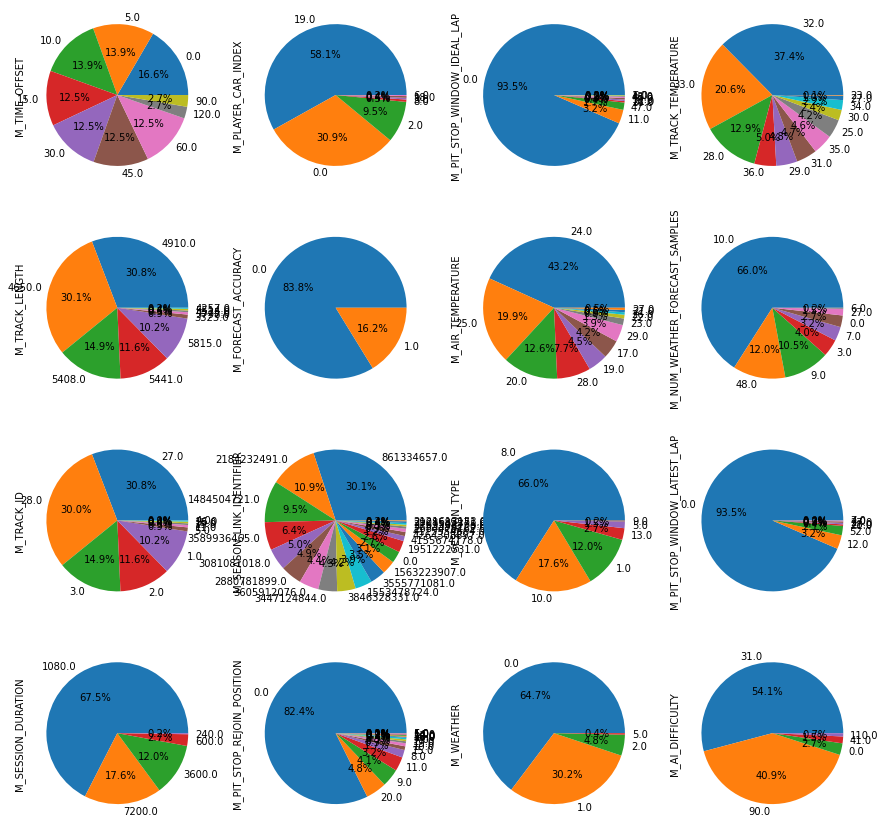

In [15]:
#discrete features
f, ax = plt.subplots(4, 4, figsize = (15 , 15))
axx = ax.flatten()

for index, col in enumerate(discrete_feats):
    df_agg[ col].value_counts().plot.pie(autopct = '%1.1f%%', ax = axx[index])

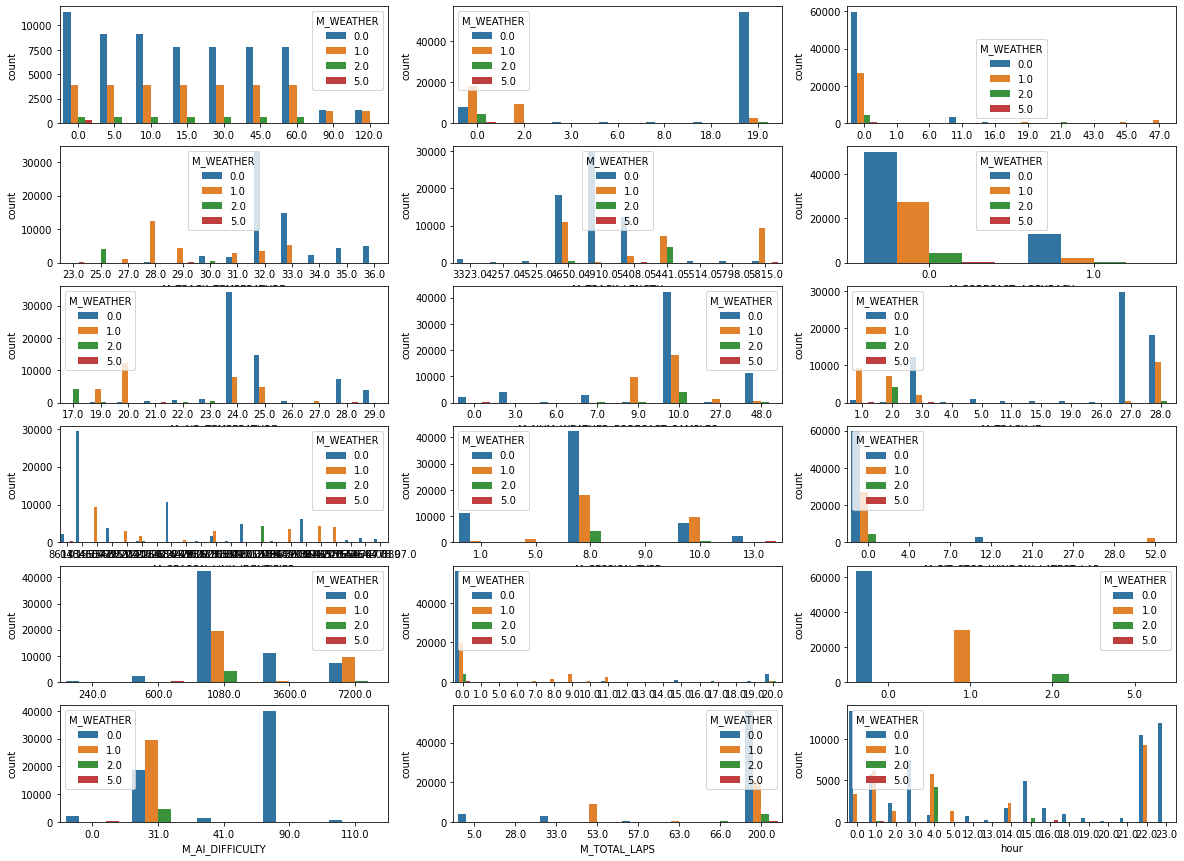

In [16]:
#bivariate analysis of categorical features with target
f, ax = plt.subplots(6, 3, figsize = (20 , 15))
axx = ax.flatten()

for index, col in enumerate(discrete_feats):
    sns.countplot(data = df_agg, x = col, hue = target, ax = axx[index])

In [17]:
# #bivariate analysis of categorical features with target
# f, ax = plt.subplots(5, 3, figsize = (20,20))
# axx = ax.flatten()
# for index, col in enumerate(cont_feats):
# #     plt.figure(figsize=(15,8))
#     sns.distplot(df_agg[col],ax=axx[index])
# #     plt.show()

## Feature Engineering

In [18]:
#mean TRACK TEMP AND AIR TEMP per session id and hour
feats_gr  = ['M_SESSION_UID','hour']
feats_agg = ['M_TRACK_TEMPERATURE','M_AIR_TEMPERATURE']
dftemp = df_agg.groupby(feats_gr)[feats_agg].agg([np.mean])
cols = dftemp.columns
dftemp.columns = ['_SessionID_Hour_'.join(c) for c in cols]
dftemp.reset_index(inplace = True)
# join df with df_agg
df_agg = df_agg.merge(dftemp, on = feats_gr, how = 'left')

#drop features by variance
dropfeats = ['M_PIT_STOP_WINDOW_IDEAL_LAP','M_FORECAST_ACCURACY']

In [19]:
# #session features 
sess_feats = ['M_SESSION_UID','M_SESSION_TYPE','M_SESSION_TIME','M_SESSION_TIME_LEFT','M_SESSION_DURATION']

### GMM

In [33]:
#get high correlated features for GMM model
highcorrelationfeats = ['M_AIR_TEMPERATURE', 'M_TRACK_TEMPERATURE_SessionID_Hour_mean','M_TRACK_TEMPERATURE']
tempdf = df_agg[highcorrelationfeats]

#Fit data using GMM
gmm = GaussianMixture(n_components=6,random_state=1)
gmm.fit(tempdf)
tempdf['GMM_CLASS'] = gmm.predict(tempdf)

#map gmm class
gmmlabel = list(tempdf.groupby(['GMM_CLASS'])['M_TRACK_TEMPERATURE'].median().sort_values(ascending=False).index.values)
weatherlabel = [0,1,2,3,4,5]
gmm_map = dict(zip(gmmlabel,weatherlabel))
#map gmm class
df_agg['WEATHER_CLASS'] = tempdf['GMM_CLASS'].map(gmm_map)

In [34]:
# for feat in tempdf.drop(columns='M_WEATHER').columns:
#     sns.displot(data=tempdf, x=feat, hue='M_WEATHER',
#                 kind='kde',palette=sns.color_palette('bright')[:4],height=4,aspect=2.2)
#     plt.show()

In [35]:
target = 'WEATHER_CLASS'
# df_agg = df_agg.drop(columns=['date'])

X = df_agg.drop(columns=['WEATHER_CLASS','M_WEATHER'])
y = df_agg[target]
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False,random_state=42)
#random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
#predict for train and validation data
pred_train = rf.predict(X_train)
pred_test = rf.predict(X_test)

metrics_print(y_train,pred_train,'train')
metrics_print(y_test,pred_test,'test')

train
ACCURACY 1.0
RECALL 1.0
PRECISION 1.0
F1-SCORE 1.0
test
ACCURACY 0.9947187423237533
RECALL 0.9947187423237533
PRECISION 0.996460772671444
F1-SCORE 0.9955369127148297


In [37]:
con_df = pd.DataFrame(list(zip(y_test.values,pred_test)),columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(con_df['y_Actual'], con_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted     0     1      2    3   4    5
Actual                                    
0          6246     0      0    0   0    0
1             0  3622     87    0   0    0
2             0     0  13654    0   0    0
3             0     0      0  671  42    0
5             0     0      0    0   0  104


### Neural Network

In [38]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [39]:
dffinal = df_agg.copy()

In [40]:
#split data into target and features
X = dffinal.drop(columns=['M_WEATHER','WEATHER_CLASS'])
Y = dffinal['WEATHER_CLASS']

#scale X using standardscaler
std_scale = StandardScaler()
X_scaled = std_scale.fit_transform(X)
X_df = pd.DataFrame(X_scaled,columns=X.columns)

#train test split 
X_train, X_test, y_train, y_test = train_test_split(X_df, Y,shuffle=False,random_state=42)

In [41]:
NN_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=X.shape[1]),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax') ])

In [42]:
NN_model.compile(Adam(lr = 0.01), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
NN_model.fit(X_train,y_train, 
          validation_data=(X_test, y_test), 
          epochs=50, batch_size=10000, verbose=1,
          )

Epoch 1/50
8/8 [==============================] - 1s 79ms/step - loss: 1.0209 - accuracy: 0.5986 - val_loss: 0.4711 - val_accuracy: 0.7348
Epoch 2/50
8/8 [==============================] - 0s 58ms/step - loss: 0.3313 - accuracy: 0.8632 - val_loss: 0.4147 - val_accuracy: 0.8554
Epoch 3/50
8/8 [==============================] - 0s 58ms/step - loss: 0.1243 - accuracy: 0.9542 - val_loss: 0.5152 - val_accuracy: 0.8720
Epoch 4/50
8/8 [==============================] - 0s 57ms/step - loss: 0.0508 - accuracy: 0.9846 - val_loss: 0.5631 - val_accuracy: 0.8911
Epoch 5/50
8/8 [==============================] - 0s 60ms/step - loss: 0.0258 - accuracy: 0.9926 - val_loss: 0.5405 - val_accuracy: 0.9097
Epoch 6/50
8/8 [==============================] - 0s 59ms/step - loss: 0.0132 - accuracy: 0.9966 - val_loss: 0.5436 - val_accuracy: 0.9128
Epoch 7/50
8/8 [==============================] - 0s 61ms/step - loss: 0.0081 - accuracy: 0.9979 - val_loss: 0.5603 - val_accuracy: 0.9040
Epoch 8/50
8/8 [===========

In [31]:
NN_model.predict(X_test)

array([[1.98771763e-26, 4.83706271e-18, 1.00000000e+00, 1.07973632e-16,
        3.09388423e-33, 1.19372997e-21],
       [1.34077188e-26, 3.31391425e-18, 1.00000000e+00, 1.00746588e-16,
        2.34819654e-33, 1.30136937e-21],
       [7.20340401e-27, 2.10124348e-18, 1.00000000e+00, 7.72459703e-17,
        1.30485594e-33, 1.09156973e-21],
       ...,
       [2.16766402e-17, 1.00000000e+00, 4.47204333e-21, 1.13138623e-30,
        0.00000000e+00, 0.00000000e+00],
       [1.40130600e-18, 1.00000000e+00, 1.14250738e-21, 1.87464048e-32,
        0.00000000e+00, 0.00000000e+00],
       [1.04431445e-17, 1.00000000e+00, 9.04132138e-22, 1.59087232e-31,
        0.00000000e+00, 0.00000000e+00]], dtype=float32)

In [45]:
# import libraries
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [46]:
#Loading the dataset
dataset = pd.read_csv('mcs_ds_edited_iter_shuffled.csv')
#For deleting observation with missing data
dataset=dataset.dropna()
dataset.head()

,anchor_ratio,trans_range,node_density,iterations,ale,sd_ale
0,30,15,200,40,0.773546,0.250555
1,15,15,100,70,0.911941,0.498329
2,30,15,100,50,0.814867,0.255546
3,15,20,100,20,1.435332,0.394603
4,30,15,100,40,1.265909,0.302943


In [47]:
#Set the columns name from the dataset file
dataset.columns = ['anchor_ratio','trans_range','node_density','iterations','ale','sd_ale']

In [48]:
dataset

,anchor_ratio,trans_range,node_density,iterations,ale,sd_ale
0,30,15,200,40,0.773546,0.250555
1,15,15,100,70,0.911941,0.498329
2,30,15,100,50,0.814867,0.255546
3,15,20,100,20,1.435332,0.394603
4,30,15,100,40,1.265909,0.302943
...,...,...,...,...,...,...
102,18,23,100,20,1.287472,0.375227
103,14,17,200,60,0.899102,0.231822
104,15,20,100,50,1.171140,0.372001
105,20,20,100,40,1.234493,0.599834


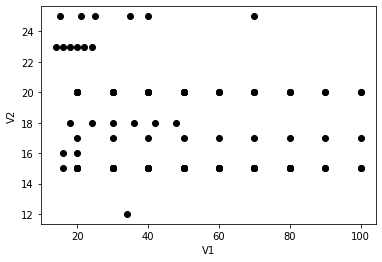

In [49]:
X = dataset[["trans_range","iterations"]]
#Visualise data points
plt.scatter(X["iterations"],X["trans_range"],c='black')
plt.xlabel('V1')
plt.ylabel('V2')
plt.show()

In [50]:
# Step 1 and 2 - Choose the number of clusters (k) and select random centroid for each cluster

#number of clusters
K=6

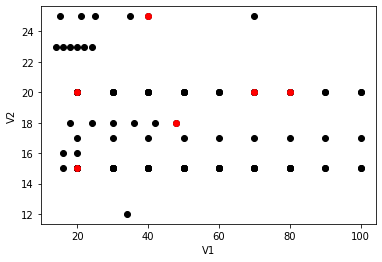

In [51]:
# Select random observation as centroids
Centroids = (X.sample(n=K))
plt.scatter(X["iterations"],X["trans_range"],c='black')
plt.scatter(Centroids["iterations"],Centroids["trans_range"],c='red')
plt.xlabel('V1')
plt.ylabel('V2')
plt.show()

In [52]:
diff = 1
j=0

while(diff!=0):
    XD=X
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["iterations"]-row_d["iterations"])
            d2=(row_c["trans_range"]-row_d["trans_range"])
            d=abs(d1-d2)
            ED.append(d)
        X[i]=ED
        i=i+1

    C=[]
    for index,row in X.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    X["Cluster"]=C
    Centroids_new = X.groupby(["Cluster"]).mean()[["trans_range","iterations"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['trans_range'] - Centroids['trans_range']).sum() + (Centroids_new['iterations'] - Centroids['iterations']).sum()

    Centroids = X.groupby(["Cluster"]).mean()[["trans_range","iterations"]]

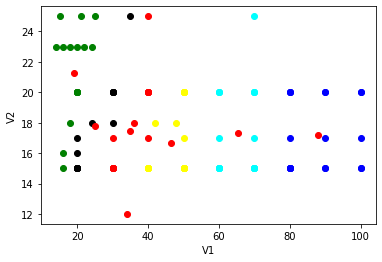

In [53]:
color=['blue','black','cyan','yellow','red','green']
for k in range(K):
    data=X[X["Cluster"]==k+1]
    plt.scatter(data["iterations"],data["trans_range"],c=color[k])
plt.scatter(Centroids["iterations"],Centroids["trans_range"],c='red')
plt.xlabel('V1')
plt.ylabel('V2')
plt.show()

In [54]:
import numpy as np
import matplotlib.pyplot as plot
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [55]:
dataset = pd.read_csv('mcs_ds_edited_iter_shuffled.csv')
#For deleting observation with missing data
dataset=dataset.dropna()


In [56]:
#Checking the top5 data in the datset
dataset.head()

,anchor_ratio,trans_range,node_density,iterations,ale,sd_ale
0,30,15,200,40,0.773546,0.250555
1,15,15,100,70,0.911941,0.498329
2,30,15,100,50,0.814867,0.255546
3,15,20,100,20,1.435332,0.394603
4,30,15,100,40,1.265909,0.302943


In [57]:
#Set the columns name from the dataset file

dataset.columns = ['anchor_ratio','trans_range','node_density','iterations','ale','sd_ale']

In [58]:
dataset

,anchor_ratio,trans_range,node_density,iterations,ale,sd_ale
0,30,15,200,40,0.773546,0.250555
1,15,15,100,70,0.911941,0.498329
2,30,15,100,50,0.814867,0.255546
3,15,20,100,20,1.435332,0.394603
4,30,15,100,40,1.265909,0.302943
...,...,...,...,...,...,...
102,18,23,100,20,1.287472,0.375227
103,14,17,200,60,0.899102,0.231822
104,15,20,100,50,1.171140,0.372001
105,20,20,100,40,1.234493,0.599834


In [59]:
X=dataset.iloc[:,[1,2]].values
#For Normalization 
standX=MinMaxScaler()
Xfinal=standX.fit_transform(X)

In [60]:
X

array([[ 15, 200],
       [ 15, 100],
       [ 15, 100],
       [ 20, 100],
       [ 15, 100],
       [ 18, 100],
       [ 23, 100],
       [ 25, 200],
       [ 25, 100],
       [ 20, 100],
       [ 20, 200],
       [ 23, 100],
       [ 23, 100],
       [ 15, 200],
       [ 20, 100],
       [ 18, 100],
       [ 17, 200],
       [ 15, 100],
       [ 17, 200],
       [ 20, 100],
       [ 15, 100],
       [ 20, 100],
       [ 20, 100],
       [ 15, 200],
       [ 20, 200],
       [ 12, 300],
       [ 20, 200],
       [ 15, 100],
       [ 20, 100],
       [ 17, 200],
       [ 15, 200],
       [ 15, 100],
       [ 15, 200],
       [ 15, 200],
       [ 23, 100],
       [ 15, 300],
       [ 15, 100],
       [ 17, 200],
       [ 20, 100],
       [ 20, 200],
       [ 16, 100],
       [ 25, 200],
       [ 15, 100],
       [ 20, 200],
       [ 15, 300],
       [ 15, 200],
       [ 15, 100],
       [ 20, 100],
       [ 15, 200],
       [ 20, 100],
       [ 20, 100],
       [ 18, 100],
       [ 15,

In [61]:
#Compute DBSCAN
#For DBSCAN with eps=0.06 and minimum sample=6
db = DBSCAN(eps=0.06, min_samples=6).fit(Xfinal)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [62]:
db

DBSCAN(eps=0.06, min_samples=6)

In [63]:
#Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points(black): %d' % n_noise_)

Estimated number of clusters: 8
Estimated number of noise points(black): 9


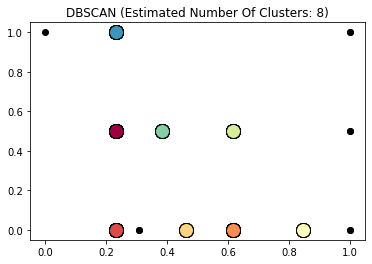

In [64]:
#Black removed and used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        #Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = Xfinal[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = Xfinal[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN (Estimated Number Of Clusters: %d)' % n_clusters_)
plt.show()

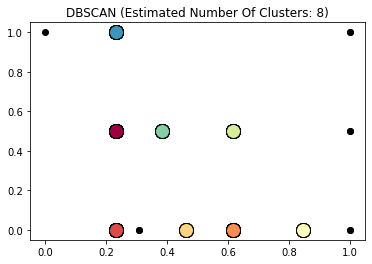

In [65]:
#For DBSCAN with eps=0.03 and minimum sample=3
db = DBSCAN(eps=0.03, min_samples=3).fit(Xfinal)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = Xfinal[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    xy = Xfinal[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
plt.title('DBSCAN (Estimated Number Of Clusters: %d)' % n_clusters_)
plt.show()